# Implemented: Conway's Game Of Life 

The following code simulates Conway's Game of Life and creates an animated visualization of it. Can you improve its performance? Try profiling the code to identify where it's taking time! (Note: you may need to use a larger grid size / increased number of timesteps to start seeing where performance needs improving.)

Simulating GOL for 100 timesteps...
Building visualization...
Progress:  10% | Elapsed:   0.7s | Remaining:   6.5s
Progress:  20% | Elapsed:   1.0s | Remaining:   3.9s
Progress:  30% | Elapsed:   1.1s | Remaining:   2.6s
Progress:  40% | Elapsed:   1.2s | Remaining:   1.8s
Progress:  50% | Elapsed:   1.3s | Remaining:   1.4s
Progress:  59% | Elapsed:   1.5s | Remaining:   1.0s
Progress:  69% | Elapsed:   1.6s | Remaining:   0.7s
Progress:  79% | Elapsed:   1.8s | Remaining:   0.5s
Progress:  89% | Elapsed:   2.0s | Remaining:   0.2s
Progress:  99% | Elapsed:   2.1s | Remaining:   0.0s
Saved animation to data/life_naive.gif


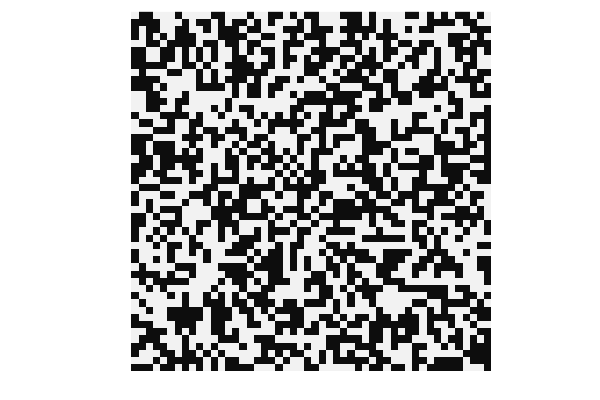

In [1]:
using Plots
using Printf
using IJulia

"""
    count_alive_neighbours(grid::Matrix{Bool}, i::Int, j::Int) -> Int

Count the number of “alive” (true) neighbors surrounding the cell at
row `i`, column `j` in a boolean grid, scanning all eight adjacent
positions. Cells outside the boundaries are ignored.

# Arguments
- `grid::Matrix{Bool}`  
  A 2D array of Booleans representing the current state of each cell
  (e.g., in Conway’s Game of Life, `true` = alive, `false` = dead).

- `i::Int`, `j::Int`  
  The 1-based row and column indices of the cell whose neighbors
  should be counted.

# Returns
- The total number of `true` values found in the eight surrounding
  cells.

# Notes
- Does *not* wrap around edges; neighbors off-grid are ignored.
- Naively checks all eight offsets (di, dj) in the range `-1:1`,
  skipping the (0,0) offset that refers to the cell itself.
"""
function count_alive_neighbours(grid::Matrix{Bool}, i::Int, j::Int)::Int
    subset_i = max(1, i - 1):min(size(grid, 1), i + 1)
    subset_j = max(1, j - 1):min(size(grid, 2), j + 1)
    return sum(grid[subset_i, subset_j]) - grid[i, j]  # don't count subject cell itself
end

"""
    next_state(grid::Matrix{Bool}) -> Matrix{Bool}

Compute the next generation of a boolean grid (e.g., for Conway’s Game of Life)
by applying the standard rules to each cell. This “naive” implementation
recalculates neighbor counts from scratch for every cell.

# Arguments
- `grid::Matrix{Bool}`  
  A 2D array of Booleans representing the current state of each cell
  (`true` = alive, `false` = dead).

# Returns
- A new 2D Boolean array of the same size as `grid`, representing the
  state of each cell in the next generation.

# Rules Applied
1. Any live cell with 2 or 3 live neighbors survives.
2. Any dead cell with exactly 3 live neighbors becomes alive.
3. All other cells die or remain dead.
"""
function next_state(grid::Matrix{Bool})::Matrix{Bool}
    # Get grid dimensions: N1 rows, N2 columns
    N1, N2 = size(grid)

    # Pre-allocate a new grid of the same size, initially all false (dead)
    newgrid = falses(N1, N2)

    # Loop over every cell position (i, j)
    for i in 1:N1, j in 1:N2
        # Count the live neighbors around (i, j)
        cnt = count_alive_neighbours(grid, i, j)


        # Apply the Game of Life rules:
        # - A live cell stays alive if it has 2 or 3 neighbors.
        # - A dead cell becomes alive if it has exactly 3 neighbors.
        # Otherwise it remains or becomes dead.
        newgrid[i,j] = (grid[i,j] && (cnt == 2 || cnt == 3)) ||
                       (!grid[i,j] && cnt == 3)
    end

    # Return the updated grid for the next generation
    return newgrid
end

"""
    simulate(initial_grid::Matrix{Bool}, steps::Int) -> Array{Bool, 3}

Simulate the Game of Life for a given number of steps.

Begins the simulation at a given initial grid configuration and runs the
simulation for the given number of timesteps.

# Arguments
- `initial_grid::Matrix{Bool}`  
  Initial boolean grid (`true` = alive, `false` = dead).

- `steps::Int`  
  Total number of generations to simulate.

# Returns
- An `Array{Bool, 3}` of the simulations, with time along the third axis.
"""
function simulate(initial_grid::Matrix{Bool}, steps::Int)::Array{Bool, 3}
    # Get grid dimensions
    N1, N2 = size(initial_grid)

    # Make 3D array with time along the third axis.
    # Starts with only a single time index corresponding to initial
    # grid.
    simulations = reshape(initial_grid, N1, N2, 1)
    
    for step in 1:steps
        # Current latest generation
        current = simulations[:, :, end]
        
        # Update simulations with next generation
        next_gen = next_state(current)
        simulations = cat(simulations, next_gen; dims=3)
    end
    
    return simulations
end

"""
    visualize_simulations(
        simulations::Array{Bool, 3};
        print_interval_percent::Int=10
    )

Produce visualizations of a Game of Life simulation.

Produces an animated GIF. A progress counter for building the animation
is controlled by `print_interval_percent`.

# Arguments
- `simulations::Array{Bool, 3}`  
  GOL simulations (`true` = alive, `false` = dead), with time along the third axis.

- `print_interval_percent::Int=10`  
  Percentage intervals at which to print animation progress updates  
  (default: every 10% of `steps`).

# Side Effects
- Prints animation progress lines to STDOUT at each interval.
- Saves `data/life_naive.gif` showing the evolution.
- Displays the animation inline if running in a notebook; otherwise, reports file path.
"""
function visualize_simulations(
        simulations::Array{Bool, 3};
        print_interval_percent::Int=10
)
    # Compute how many steps correspond to one print interval:
    # at least 1, scaled by the given percentage of total steps
    n_steps = size(simulations, 3)
    step_interval = max(1, floor(Int, n_steps * print_interval_percent / 100))

    t_start = time()
    anim = @animate for step in axes(simulations, 3)
        # If we've reached a print interval, output progress stats
        if step % step_interval == 0
            pct     = step / n_steps * 100
            elapsed = time() - t_start
            avg     = elapsed / step
            remain  = avg * (n_steps - step)
            @printf("Progress: %3.0f%% | Elapsed: %5.1fs | Remaining: %5.1fs\n",
                    pct, elapsed, remain)
        end

        # Generate a heatmap frame for the current grid state
        heatmap(
            view(simulations, :, :, step);
            color = :grays,
            axis = false,
            legend = false,
            framestyle = :none,
            aspect_ratio = 1
        )
    end
    
    # Ensure the “data” directory exists
    mkpath("data")

    # Write the animation to GIF at 10 frames per second
    gif(anim, "data/life_naive.gif"; fps = 10, show_msg=false)
    println("Saved animation to data/life_naive.gif")
    
    # Detect if running inside a Jupyter notebook
    in_notebook = isdefined(Main, :IJulia) && IJulia.inited
 
    if in_notebook
        # Display the GIF inline in the notebook
        display("image/gif", read("data/life_naive.gif"))
    else
        # Otherwise, instruct the user to open the files manually
        println("Not running in a notebook.")
        println("Open `data/life_naive.gif` in your OS image viewer to see the results.")
    end
end

#─── Main Simulation Function ───────────────────────────────────────────────────

"""
    run(grid::Matrix{Bool}, steps::Int; print_interval_percent::Int=10)

Run the Game of Life simulation for a given number of steps.

Produces an animated GIF and a final heatmap of activity. A progress
counter for building the animated GIF is controlled by `print_interval_percent`.

# Arguments
- `grid::Matrix{Bool}`  
  Initial boolean grid (`true` = alive, `false` = dead).

- `steps::Int`  
  Total number of generations to simulate.

- `print_interval_percent::Int=10`  
  Percentage intervals at which to print animation progress updates  
  (default: every 10% of `steps`).

# Side Effects
- Prints animation progress lines to STDOUT at each interval.
- Saves `data/life_naive.gif` showing the evolution.
- Saves `data/life_history_heatmap.png` showing the total times each cell was alive.
- Displays the animation and heatmap inline if running in a notebook; otherwise, reports file paths.
"""
function run(grid::Matrix{Bool}, steps::Int; print_interval_percent::Int=10)
    # Simulate GOL
    println("Simulating GOL for $(steps) timesteps...")
    simulations = simulate(grid, steps)

    # Create an animation by collecting each timeslice of the simulation
    # as frames in the @animate block
    println("Building visualization...")
    visualize_simulations(simulations; print_interval_percent=print_interval_percent)
end

# Example usage:
# Create a 50×50 grid with random alive/dead cells and run
# the naive Game of Life simulation for 100 steps,
# printing progress every 10% of the total steps.
grid = rand(Bool, 50, 50)
steps = 100
run(grid, steps)